In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# === Load raw EEG data === #
DATA_PATH = 'data/anshu_signal.csv'
df = pd.read_csv(DATA_PATH)

# Remove timestamp, keep only Fp1 and Fp2
df = df[['Fp1', 'Fp2']]

# Convert to float and normalize
df = df.astype(float)
df = (df - df.mean()) / df.std()  # Normalization

# === Label Creation === #
total_samples = len(df)
if total_samples % 2 != 0:
    df = df[:-1]
    total_samples -= 1

half = total_samples // 2
labels = np.array([0] * half + [1] * half)  # 0: Relax, 1: Stress

# === Reshape for CNN === #
eeg_data = df.to_numpy().reshape((-1, 1, 2))

# One-hot encode labels
one_hot_labels = np.zeros((len(labels), 2))
one_hot_labels[np.arange(len(labels)), labels] = 1

# === Train-test Split === #
X_train, X_test, y_train, y_test = train_test_split(
    eeg_data, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels
)


In [2]:
# Build model
model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, 2)),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,338
Trainable params: 2,338
Non-trainable params: 0
______________________________________________________

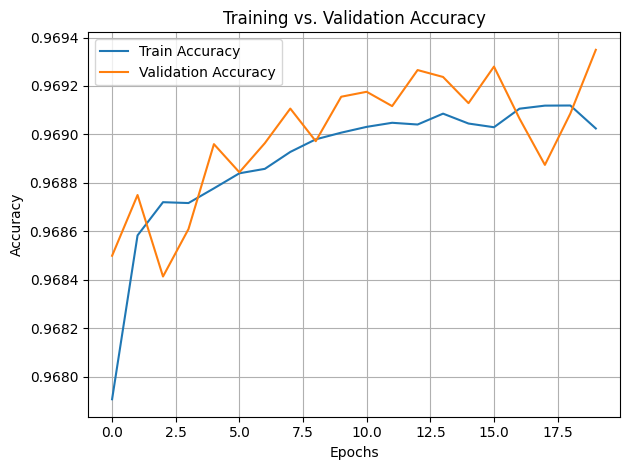

In [3]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


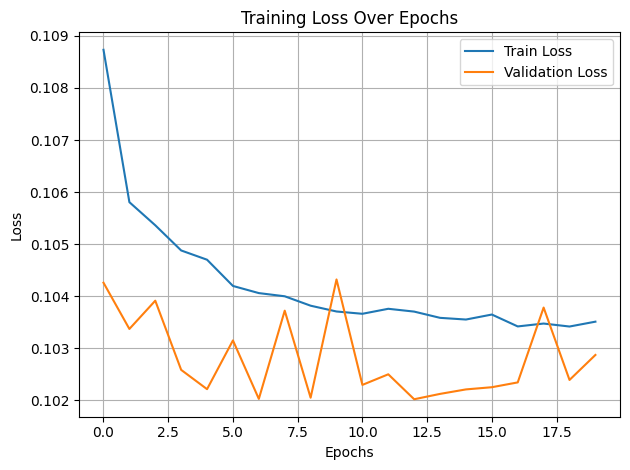

In [4]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


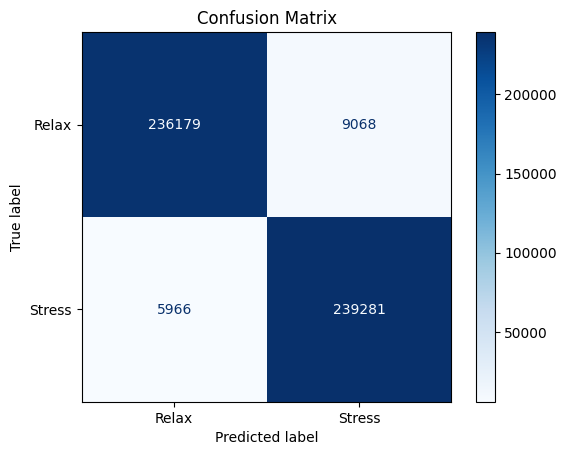

In [5]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relax", "Stress"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


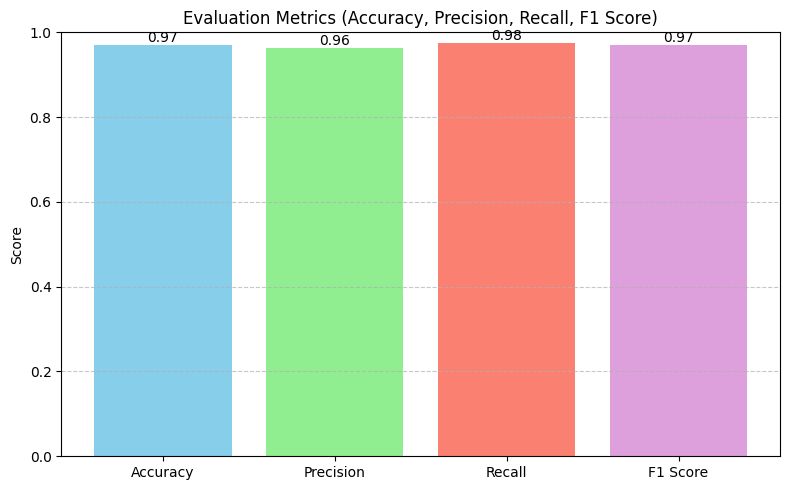

Accuracy: 96.93%
Precision: 0.9635
Recall: 0.9757
F1 Score: 0.9695


In [6]:
# Compute classification metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

# Metrics and labels
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics (Accuracy, Precision, Recall, F1 Score)')
plt.ylabel('Score')

# Add text annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")